# WGAN Training - CIFAR-10 Horses

This notebook trains a Wasserstein GAN (WGAN) on the CIFAR-10 dataset to
generate realistic horse images.

## Features

- **Weight Clipping**: Lipschitz constraint via weight clipping
- **Wasserstein Loss**: Meaningful loss for training stability
- **No BatchNorm in Critic**: Standard WGAN architecture
- **W&B Integration**: Full experiment tracking with Weights & Biases

## Architecture

- **Critic**: 4-layer CNN (no sigmoid, outputs unbounded scores)
- **Generator**: 4-layer deconvolution with upsampling

## References

- Arjovsky et al. "Wasserstein GAN" (2017)
- Chapter 4 of "Generative Deep Learning" book

## GPU Memory Setup

Configure TensorFlow to use memory growth, preventing OOM errors.

In [1]:
# =============================================================================
# GPU MEMORY CONFIGURATION
# =============================================================================
# Enable memory growth to prevent TensorFlow from allocating all GPU memory
# at once. This must be done BEFORE any other TensorFlow operations.

import tensorflow as tf

# Get list of available GPUs
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    # Enable memory growth for each GPU to prevent OOM errors
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"✓ GPU(s) available: {[gpu.name for gpu in gpus]}")
else:
    print("⚠ WARNING: No GPU detected, running on CPU")

2026-01-07 06:45:01.937894: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/cataluna84/Workspace-Antigravity/Generative_Deep_Learning/.venv/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


✓ GPU(s) available: ['/physical_device:GPU:0']


## Imports

Import all required modules including TensorFlow, visualization libraries,
project-specific WGAN model, data loaders, and experiment tracking.

In [2]:
# =============================================================================
# IMPORTS
# =============================================================================

# -----------------------------------------------------------------------------
# Enable inline plotting for Jupyter notebooks
# -----------------------------------------------------------------------------
%matplotlib inline

# -----------------------------------------------------------------------------
# Standard Library
# -----------------------------------------------------------------------------
import os
import sys

# -----------------------------------------------------------------------------
# Third-Party Libraries
# -----------------------------------------------------------------------------
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------------------------------------------------------
# Path Configuration
# Add parent directories to system path for accessing modules
# -----------------------------------------------------------------------------
sys.path.insert(0, "..")       # For v1/src modules
sys.path.insert(0, "../..")    # For project root utils/

# -----------------------------------------------------------------------------
# Project Modules
# -----------------------------------------------------------------------------
# WGAN: Wasserstein GAN implementation with critic (not discriminator)
from src.models.WGAN import WGAN

# load_cifar: Loads CIFAR-10/100 dataset filtered by class label
# Returns images normalized to [-1, 1] range
from src.utils.loaders import load_cifar

# -----------------------------------------------------------------------------
# Experiment Tracking
# -----------------------------------------------------------------------------
import wandb
from utils.wandb_utils import init_wandb, log_images

## Global Configuration

Define run parameters including experiment identification, output directories,
and training mode (build new model or load existing weights).

In [3]:
# =============================================================================
# GLOBAL CONFIGURATION
# =============================================================================
# These values define the experiment identity and output locations.

# -----------------------------------------------------------------------------
# Run Identification
# -----------------------------------------------------------------------------
SECTION = 'gan'          # Parent folder for all GAN experiments
RUN_ID = '0002'          # Unique identifier for this run
DATA_NAME = 'horses'     # Dataset/class name (CIFAR-10 class 7)
RUN_FOLDER = f'../run/{SECTION}/{RUN_ID}_{DATA_NAME}'

# -----------------------------------------------------------------------------
# Create Output Directories
# - viz: Training visualization plots (loss curves, etc.)
# - images: Generated sample images at checkpoints
# - weights: Model weight checkpoints
# -----------------------------------------------------------------------------
if not os.path.exists(RUN_FOLDER):
    os.makedirs(RUN_FOLDER)
    os.makedirs(os.path.join(RUN_FOLDER, 'viz'))
    os.makedirs(os.path.join(RUN_FOLDER, 'images'))
    os.makedirs(os.path.join(RUN_FOLDER, 'weights'))

# Training mode: 'build' creates new model, 'load' resumes from checkpoint
MODE = 'build'

print(f"Run folder: {RUN_FOLDER}")
print(f"Mode: {MODE}")

Run folder: ../run/gan/0002_horses
Mode: build


## Data Loading

Load the CIFAR-10 dataset filtered to a specific class (horses = label 7).
Images are 32x32 RGB and normalized to [-1, 1] range for GAN training.

**CIFAR-10 Class Labels:**
- 0: airplane, 1: automobile, 2: bird, 3: cat, 4: deer
- 5: dog, 6: frog, 7: horse, 8: ship, 9: truck

In [4]:
# =============================================================================
# DATA LOADING
# =============================================================================
# Load CIFAR-10 dataset filtered by class label.
# The load_cifar function:
#   1. Downloads CIFAR-10 if not present
#   2. Filters images by the specified label
#   3. Normalizes pixel values from [0, 255] to [-1, 1]

# Map data name to CIFAR-10 class label
CIFAR_LABELS = {
    'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4,
    'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9,
    # Alternate names
    'cars': 1, 'horses': 7
}

# Get label from data name (default to horses if not found)
label = CIFAR_LABELS.get(DATA_NAME, 7)

# Load filtered dataset
# Parameters:
#   - label: Class index to filter (7 = horses)
#   - 10: Use CIFAR-10 (vs CIFAR-100)
(x_train, y_train) = load_cifar(label, 10)

# Print dataset information
print(f"Dataset: CIFAR-10 ({DATA_NAME})")
print(f"Training samples: {x_train.shape[0]:,}")
print(f"Image dimensions: {x_train.shape[1:]}")
print(f"Data type: {x_train.dtype}")
print(f"Value range: [{x_train.min():.2f}, {x_train.max():.2f}]")

/home/cataluna84/Workspace-Antigravity/Generative_Deep_Learning/.venv/lib/python3.13/site-packages/keras/src/datasets/cifar.py:18: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  d = cPickle.load(f, encoding="bytes")


Dataset: CIFAR-10 (horses)
Training samples: 6,000
Image dimensions: (32, 32, 3)
Data type: float32
Value range: [-1.00, 1.00]


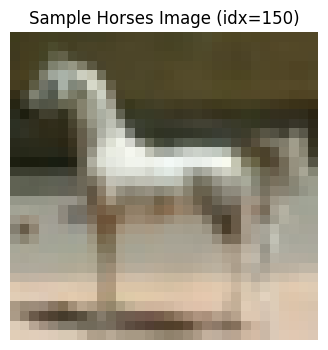

In [5]:
# =============================================================================
# SAMPLE VISUALIZATION
# =============================================================================
# Display a sample image from the dataset.
# Note: Images are rescaled from [-1, 1] to [0, 1] for proper display.

# Select random sample and rescale for visualization
sample_idx = 150
sample_img = (x_train[sample_idx, :, :, :] + 1) / 2  # Rescale [-1,1] -> [0,1]

plt.figure(figsize=(4, 4))
plt.imshow(sample_img)
plt.title(f'Sample {DATA_NAME.capitalize()} Image (idx={sample_idx})')
plt.axis('off')
plt.show()

## Model Hyperparameters

Define all model architecture hyperparameters as global constants.

**Why global constants?** Following the DRY (Don't Repeat Yourself) principle,
we define hyperparameters once and reference them in both model creation
and W&B config. This prevents inconsistencies and makes experiments easier to modify.

In [6]:
# =============================================================================
# MODEL HYPERPARAMETERS
# =============================================================================
# Define all architecture hyperparameters as global constants.
# These are used for both model creation AND W&B config logging.
#
# Best Practice: Define hyperparameters once in a central location to:
#   1. Avoid duplication and potential inconsistencies
#   2. Make experiment configuration changes easy
#   3. Ensure W&B logs match actual model parameters
# =============================================================================

# -----------------------------------------------------------------------------
# Input Configuration
# -----------------------------------------------------------------------------
INPUT_DIM = (32, 32, 3)       # CIFAR-10 image dimensions
Z_DIM = 100                    # Latent space dimension

# -----------------------------------------------------------------------------
# Critic (Discriminator) Configuration
# -----------------------------------------------------------------------------
CRITIC_FILTERS = [32, 64, 128, 128]
CRITIC_KERNEL_SIZE = [5, 5, 5, 5]
CRITIC_STRIDES = [2, 2, 2, 1]
CRITIC_ACTIVATION = 'leaky_relu'
CRITIC_LEARNING_RATE = 0.00005

# -----------------------------------------------------------------------------
# Generator Configuration
# -----------------------------------------------------------------------------
GENERATOR_INITIAL_SIZE = (4, 4, 128)
GENERATOR_UPSAMPLE = [2, 2, 2, 1]
GENERATOR_FILTERS = [128, 64, 32, 3]
GENERATOR_KERNEL_SIZE = [5, 5, 5, 5]
GENERATOR_STRIDES = [1, 1, 1, 1]
GENERATOR_BATCH_NORM_MOMENTUM = 0.8
GENERATOR_ACTIVATION = 'leaky_relu'
GENERATOR_LEARNING_RATE = 0.00005

# -----------------------------------------------------------------------------
# Optimizer
# -----------------------------------------------------------------------------
OPTIMIZER = 'rmsprop'

print("✓ Model hyperparameters defined")

✓ Model hyperparameters defined


## Model Architecture

Build the WGAN with critic and generator networks using the global hyperparameters.

### Critic Architecture (replaces Discriminator)
- 4 convolutional layers with increasing filters
- LeakyReLU activation (no BatchNorm - important for WGAN stability)
- No sigmoid output - produces unbounded "realness" score
- Uses RMSprop optimizer with low learning rate

### Generator Architecture
- Dense layer → Reshape to 4×4×128
- 4 upsampling + conv layers to reach 32×32×3
- BatchNorm + LeakyReLU after each conv layer
- Tanh output activation for [-1, 1] range

### Key WGAN Differences from Standard GAN
- **Critic vs Discriminator**: Outputs real number (not probability)
- **Weight Clipping**: Enforces Lipschitz constraint
- **Wasserstein Loss**: More meaningful gradient signal

In [7]:
# =============================================================================
# MODEL ARCHITECTURE
# =============================================================================
# Build the WGAN using the global hyperparameters defined above.
# This ensures consistency between model and W&B config.

if MODE == 'build':
    gan = WGAN(
        # Input configuration (uses global constants)
        input_dim=INPUT_DIM,
        z_dim=Z_DIM,

        # Critic configuration (uses global constants)
        critic_conv_filters=CRITIC_FILTERS,
        critic_conv_kernel_size=CRITIC_KERNEL_SIZE,
        critic_conv_strides=CRITIC_STRIDES,
        critic_batch_norm_momentum=None,
        critic_activation=CRITIC_ACTIVATION,
        critic_dropout_rate=None,
        critic_learning_rate=CRITIC_LEARNING_RATE,

        # Generator configuration (uses global constants)
        generator_initial_dense_layer_size=GENERATOR_INITIAL_SIZE,
        generator_upsample=GENERATOR_UPSAMPLE,
        generator_conv_filters=GENERATOR_FILTERS,
        generator_conv_kernel_size=GENERATOR_KERNEL_SIZE,
        generator_conv_strides=GENERATOR_STRIDES,
        generator_batch_norm_momentum=GENERATOR_BATCH_NORM_MOMENTUM,
        generator_activation=GENERATOR_ACTIVATION,
        generator_dropout_rate=None,
        generator_learning_rate=GENERATOR_LEARNING_RATE,

        # Optimizer (uses global constant)
        optimiser=OPTIMIZER
    )
    # Save model architecture and config to run folder
    gan.save(RUN_FOLDER)
    print("✓ WGAN model built successfully")

else:
    # Load pre-trained weights for continued training or inference
    gan.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))
    print("✓ Loaded weights from checkpoint")

I0000 00:00:1767768316.817643    5497 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6094 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5


✓ WGAN model built successfully


### Critic Summary

Display the critic network architecture showing layer dimensions and parameters.

In [8]:
# =============================================================================
# CRITIC ARCHITECTURE SUMMARY
# =============================================================================
# The critic is trained to distinguish real from generated images,
# outputting a higher score for more "real-looking" inputs.

gan.critic.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ critic_input (InputLayer)       │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ critic_conv_0 (Conv2D)          │ (None, 16, 16, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ critic_conv_1 (Conv2D)          │ (None, 8, 8, 64)       │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ critic_conv_2 (Conv2D)          │ (None, 4, 4, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ critic_conv_3 (Conv2D)          │ (None, 4, 4, 128)      │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 670,401 (2.56 MB)

 Trainable params: 670,401 (2.56 MB)

 Non-trainable params: 0 (0.00 B)

### Generator Summary

Display the generator network architecture showing layer dimensions and parameters.

In [9]:
# =============================================================================
# GENERATOR ARCHITECTURE SUMMARY
# =============================================================================
# The generator transforms random noise vectors into realistic images,
# trained to maximize the critic's score on generated samples.

gan.generator.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ generator_input (InputLayer)    │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2048)           │       206,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ generator_conv_0 (Conv2D)       │ (None, 8, 8, 128)      │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ generator_conv_1 (Conv2D)       │ (None, 16, 16, 64)     │       204,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ generator_conv_2 (Conv2D)       │ (None, 32, 32, 32)     │        51,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ generator_conv_3                │ (None, 32, 32, 3)      │         2,403 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 3)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 884,163 (3.37 MB)

 Trainable params: 879,619 (3.36 MB)

 Non-trainable params: 4,544 (17.75 KB)

## Training Configuration

Define training hyperparameters specific to WGAN training.

**Key WGAN Training Parameters:**
- **N_CRITIC**: Number of critic updates per generator update (typically 5)
- **CLIP_THRESHOLD**: Weight clipping value for Lipschitz constraint
- **BATCH_SIZE**: Samples per training step
- **EPOCHS**: Total training iterations

In [10]:
# =============================================================================
# TRAINING CONFIGURATION
# =============================================================================
# WGAN-specific hyperparameters for stable training.

# -----------------------------------------------------------------------------
# Batch and Epoch Settings
# -----------------------------------------------------------------------------
BATCH_SIZE = 512          # Number of samples per training step
EPOCHS = 6000             # Total training epochs

# -----------------------------------------------------------------------------
# Checkpoint Settings
# -----------------------------------------------------------------------------
PRINT_EVERY_N_BATCHES = 50  # Save images/weights every N batches

# -----------------------------------------------------------------------------
# WGAN-Specific Parameters
# -----------------------------------------------------------------------------
# N_CRITIC: Train critic N times per generator update
# This ensures the critic provides accurate gradients to the generator
N_CRITIC = 5

# CLIP_THRESHOLD: Clip critic weights to [-c, c] after each update
# This enforces the Lipschitz constraint required for Wasserstein distance
CLIP_THRESHOLD = 0.01

print("════════════════════════════════════════════════════════════════")
print("WGAN TRAINING CONFIGURATION")
print("════════════════════════════════════════════════════════════════")
print(f"Batch Size:       {BATCH_SIZE}")
print(f"Epochs:           {EPOCHS}")
print(f"Critic Steps:     {N_CRITIC} per generator step")
print(f"Weight Clip:      ±{CLIP_THRESHOLD}")
print(f"Checkpoint:       Every {PRINT_EVERY_N_BATCHES} batches")
print("════════════════════════════════════════════════════════════════")

════════════════════════════════════════════════════════════════
WGAN TRAINING CONFIGURATION
════════════════════════════════════════════════════════════════
Batch Size:       512
Epochs:           6000
Critic Steps:     5 per generator step
Weight Clip:      ±0.01
Checkpoint:       Every 50 batches
════════════════════════════════════════════════════════════════


## W&B Experiment Tracking

Initialize Weights & Biases for logging training metrics and generated samples.
All hyperparameters reference the global constants defined above to ensure consistency.

In [11]:
# =============================================================================
# W&B INITIALIZATION
# =============================================================================
# Initialize Weights & Biases for experiment tracking.
# Config uses the global constants defined above - no duplication!

run = init_wandb(
    name=f"wgan_{DATA_NAME}_{RUN_ID}",
    project="generative-deep-learning",
    config={
        # Model type and dataset
        "model_type": "WGAN",
        "dataset": f"cifar10_{DATA_NAME}",

        # Input configuration (references global constants)
        "input_dim": INPUT_DIM,
        "z_dim": Z_DIM,

        # Critic configuration (references global constants)
        "critic_filters": CRITIC_FILTERS,
        "critic_activation": CRITIC_ACTIVATION,
        "critic_learning_rate": CRITIC_LEARNING_RATE,

        # Generator configuration (references global constants)
        "generator_filters": GENERATOR_FILTERS,
        "generator_activation": GENERATOR_ACTIVATION,
        "generator_learning_rate": GENERATOR_LEARNING_RATE,
        "generator_batch_norm_momentum": GENERATOR_BATCH_NORM_MOMENTUM,

        # Training configuration (references global constants)
        "batch_size": BATCH_SIZE,
        "epochs": EPOCHS,
        "n_critic": N_CRITIC,
        "clip_threshold": CLIP_THRESHOLD,
        "optimizer": OPTIMIZER,
    }
)
print(f"✓ W&B run initialized: {run.name}")
print(f"  View at: {run.url}")

wandb: Currently logged in as: cataluna84 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


✓ W&B run initialized: wgan_horses_0002
  View at: https://wandb.ai/cataluna84/generative-deep-learning/runs/x5ln97by


### Training Execution

Start the WGAN training loop. The training process:
1. **Critic Phase**: Update critic N_CRITIC times using real and fake batches
2. **Weight Clipping**: Clip critic weights to enforce Lipschitz constraint
3. **Generator Phase**: Update generator once to fool the critic
4. **Logging**: Save samples and weights at regular intervals

In [12]:
# =============================================================================
# TRAINING EXECUTION
# =============================================================================
# Train the WGAN using the Wasserstein training procedure:
#   1. Sample real images from training set
#   2. Generate fake images from random noise
#   3. Train critic to maximize: E[critic(real)] - E[critic(fake)]
#   4. Clip critic weights to [-CLIP_THRESHOLD, CLIP_THRESHOLD]
#   5. Train generator to maximize: E[critic(fake)]
#   6. Repeat critic steps N_CRITIC times per generator step

gan.train(
    x_train,                              # Training data
    batch_size=BATCH_SIZE,                # Samples per batch
    epochs=EPOCHS,                        # Total epochs
    run_folder=RUN_FOLDER,                # Output directory
    print_every_n_batches=PRINT_EVERY_N_BATCHES,  # Checkpoint frequency
    n_critic=N_CRITIC,                    # Critic updates per generator update
    clip_threshold=CLIP_THRESHOLD         # Weight clipping value
)

2026-01-07 06:45:25.051388: I external/local_xla/xla/service/service.cc:163] XLA service 0x782ca8004be0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-01-07 06:45:25.051442: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 2070, Compute Capability 7.5
2026-01-07 06:45:25.104102: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-01-07 06:45:25.224300: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91701
2026-01-07 06:45:26.196627: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,64,16,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,16,16]{3,2,1,0}, f32[64,128,5,5]{3,2,1,0}, f32[64]{0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call

0 [D loss: (0.000)(R 0.000, F 0.000)]  [G loss: -0.000] 


2026-01-07 06:45:53.502155: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[25,64,16,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[25,128,16,16]{3,2,1,0}, f32[64,128,5,5]{3,2,1,0}, f32[64]{0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2026-01-07 06:45:53.630671: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[25,32,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[25,64,32,32]{3,2,1,0}, f32[32,64,5,5]{3,2,1,0}, f32[32]{0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="_

1 [D loss: (0.000)(R 0.000, F 0.000)]  [G loss: -0.001] 
2 [D loss: (-0.000)(R -0.000, F 0.000)]  [G loss: -0.001] 
3 [D loss: (-0.000)(R -0.000, F -0.000)]  [G loss: -0.001] 
4 [D loss: (-0.000)(R -0.000, F -0.000)]  [G loss: -0.001] 
5 [D loss: (-0.000)(R -0.000, F -0.000)]  [G loss: -0.002] 
6 [D loss: (-0.000)(R -0.000, F -0.000)]  [G loss: -0.002] 
7 [D loss: (-0.000)(R -0.000, F -0.000)]  [G loss: -0.002] 
8 [D loss: (-0.000)(R -0.000, F -0.000)]  [G loss: -0.002] 
9 [D loss: (-0.000)(R -0.000, F -0.000)]  [G loss: -0.003] 
10 [D loss: (-0.000)(R -0.000, F -0.000)]  [G loss: -0.003] 
11 [D loss: (-0.000)(R -0.000, F -0.000)]  [G loss: -0.003] 
12 [D loss: (-0.000)(R -0.000, F -0.000)]  [G loss: -0.003] 
13 [D loss: (-0.000)(R -0.000, F -0.000)]  [G loss: -0.004] 
14 [D loss: (-0.000)(R -0.000, F -0.000)]  [G loss: -0.004] 
15 [D loss: (-0.000)(R -0.000, F -0.000)]  [G loss: -0.004] 
16 [D loss: (-0.000)(R -0.000, F -0.000)]  [G loss: -0.005] 
17 [D loss: (-0.000)(R -0.000, F -0.0

In [13]:
# =============================================================================
# GENERATE FINAL SAMPLES
# =============================================================================
# Generate and save a grid of sample images using the trained generator.
# This provides a quick visual check of generation quality after training.

gan.sample_images(RUN_FOLDER)
print(f"✓ Sample images saved to: {RUN_FOLDER}/images/")

✓ Sample images saved to: ../run/gan/0002_horses/images/


## Log Training Metrics to W&B

Log final training metrics and loss curves to Weights & Biases for experiment comparison.

In [14]:
# =============================================================================
# LOG TRAINING METRICS TO W&B
# =============================================================================
# Log final metrics and loss history for experiment comparison.

# Log final loss values
final_d_loss = gan.d_losses[-1] if gan.d_losses else [0, 0, 0]
final_g_loss = gan.g_losses[-1] if gan.g_losses else 0

wandb.log({
    "final_d_loss": final_d_loss[0],
    "final_d_loss_real": final_d_loss[1],
    "final_d_loss_fake": final_d_loss[2],
    "final_g_loss": final_g_loss,
    "total_epochs": len(gan.d_losses),
})

# Log loss history as table for visualization
loss_table = wandb.Table(
    columns=["epoch", "d_loss", "d_loss_real", "d_loss_fake", "g_loss"]
)
for i, (d_loss, g_loss) in enumerate(zip(gan.d_losses, gan.g_losses)):
    loss_table.add_data(i, d_loss[0], d_loss[1], d_loss[2], g_loss)

wandb.log({"loss_history": loss_table})

print("✓ Training metrics logged to W&B")

✓ Training metrics logged to W&B


## Post-Training Analysis

Run automated stability analysis and generate reports.
This cell:
1. Analyzes training dynamics using rules-based stability checks
2. Logs phase metrics and stability indicators to W&B
3. Generates a markdown analysis report in the run folder

In [ ]:
# =============================================================================
# POST-TRAINING ANALYSIS
# =============================================================================
# Run automated stability analysis and log to W&B + markdown report.

from utils.gan.stability_analysis import analyze_training_run
from utils.gan.report_generator import generate_run_report
from utils.wandb_utils import log_training_report

# -----------------------------------------------------------------------------
# Run Automated Stability Analysis
# -----------------------------------------------------------------------------
# Analyze training dynamics from loss curves
analysis = analyze_training_run(gan.d_losses, gan.g_losses)

# Print verdict summary
print("═" * 60)
print("TRAINING ANALYSIS VERDICT")
print("═" * 60)
print(f"Stability:    {analysis['verdict']['stability']}")
print(f"Quality:      {analysis['verdict']['quality']}")
print(f"Score:        {analysis['verdict']['passed']}/{analysis['verdict']['total']} checks passed")
print(f"Recommendation: {analysis['verdict']['recommendation']}")
print("═" * 60)

# Print stability indicators
print("\nStability Indicators:")
for name, (passed, obs) in analysis['indicators'].items():
    status = "✅" if passed else "❌"
    print(f"  {status} {name.replace('_', ' ').title()}: {obs}")

# -----------------------------------------------------------------------------
# Log Complete Analysis to W&B
# -----------------------------------------------------------------------------
# Build config dict from global constants for logging
config = {
    "batch_size": BATCH_SIZE,
    "epochs": EPOCHS,
    "lr_critic": CRITIC_LEARNING_RATE,
    "lr_generator": GENERATOR_LEARNING_RATE,
    "optimizer": OPTIMIZER,
    "z_dim": Z_DIM,
    "n_critic": N_CRITIC,
    "clip_threshold": CLIP_THRESHOLD,
    "input_dim": INPUT_DIM,
    "critic_filters": CRITIC_FILTERS,
    "generator_filters": GENERATOR_FILTERS,
}

# Log to W&B
log_training_report(
    config=config,
    analysis=analysis,
    run_folder=RUN_FOLDER,
    notes="Baseline run with default hyperparameters"
)

# -----------------------------------------------------------------------------
# Generate Markdown Report
# -----------------------------------------------------------------------------
# Save analysis report to run folder
report_path = generate_run_report(
    run_folder=RUN_FOLDER,
    config=config,
    d_losses=gan.d_losses,
    g_losses=gan.g_losses,
    wandb_url=wandb.run.url if wandb.run else None,
    notes="Baseline run with default hyperparameters"
)

print(f"\n✓ Analysis complete! Report saved to: {report_path}")



## Wasserstein Loss Visualization

This cell visualizes the training dynamics of the WGAN by plotting the Wasserstein distance over training epochs.

**What the plots show:**
- **Black line**: Combined critic loss (D loss) - the average of real and fake losses
- **Green line**: Critic loss on real images (R) - how well the critic scores real samples
- **Red line**: Critic loss on fake images (F) - how well the critic scores generated samples
- **Orange line**: Generator loss (G loss) - the Wasserstein distance estimate

**Why this matters:**
Unlike standard GANs, the WGAN loss is meaningful - the negative generator loss approximates the Earth Mover's Distance between real and generated distributions. A steadily decreasing (more negative) G loss indicates the generator is improving.

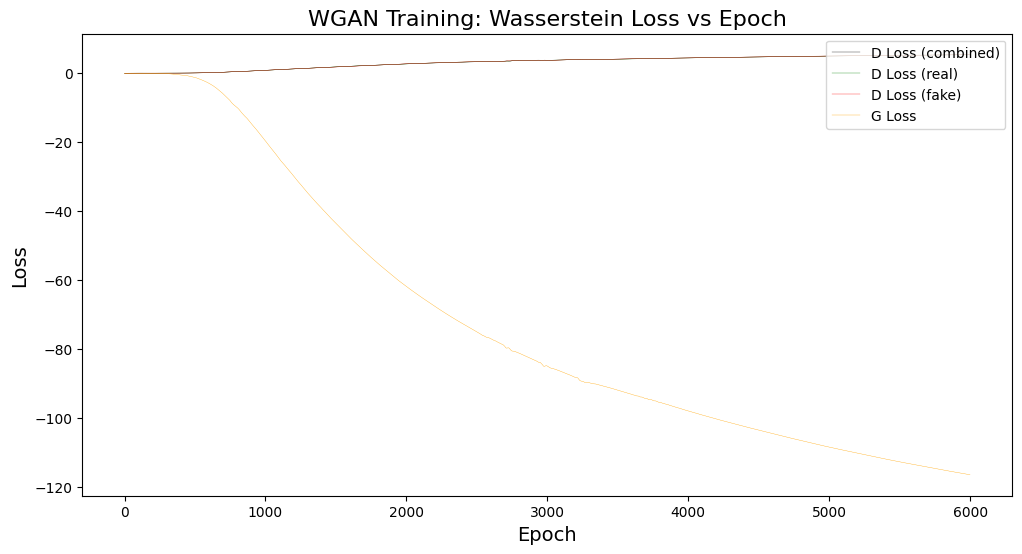

Saved loss plot to: ../run/gan/0002_horses/wassersteinloss_vs_batch.png


In [15]:
# =============================================================================
# Wasserstein Loss Plot
# =============================================================================
# This plot shows the progression of critic and generator losses during
# training. The Wasserstein distance serves as a measure of how well the
# generator is learning to approximate the real data distribution.
# =============================================================================

# Create figure for the loss visualization
fig = plt.figure(figsize=(12, 6))

# Plot critic losses:
# - d_losses[0]: Combined D loss (average of real and fake)
# - d_losses[1]: D loss on real images (R)
# - d_losses[2]: D loss on fake images (F)
plt.plot(
    [x[0] for x in gan.d_losses],
    color="black",
    linewidth=0.25,
    label="D Loss (combined)"
)
plt.plot(
    [x[1] for x in gan.d_losses],
    color="green",
    linewidth=0.25,
    label="D Loss (real)"
)
plt.plot(
    [x[2] for x in gan.d_losses],
    color="red",
    linewidth=0.25,
    label="D Loss (fake)"
)

# Plot generator loss (Wasserstein distance estimate)
plt.plot(gan.g_losses, color="orange", linewidth=0.25, label="G Loss")

# Configure axis labels and legend
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.title("WGAN Training: Wasserstein Loss vs Epoch", fontsize=16)
plt.legend(loc="upper right")

# Display the figure in the notebook
plt.show()

# Save the figure to the run folder for later reference
fig.savefig(os.path.join(RUN_FOLDER, "wassersteinloss_vs_batch.png"), dpi=300)
print(f"Saved loss plot to: {os.path.join(RUN_FOLDER, 'wassersteinloss_vs_batch.png')}")

# Log loss plot to W&B
wandb.log({"loss_plot": wandb.Image(fig)})

## Image Comparison Utility

Define a helper function to compare images using Mean Absolute Error (MAE).

In [16]:
def compare_images(img1, img2):
    """
    Compute Mean Absolute Error (MAE) between two images.

    Parameters
    ----------
    img1 : np.ndarray
        First image array.
    img2 : np.ndarray
        Second image array (same shape as img1).

    Returns
    -------
    float
        Mean absolute difference between the two images.
    """
    return np.mean(np.abs(img1 - img2))

## Real Training Images Grid

This cell displays a 5x5 grid of randomly sampled real training images from the CIFAR-10 horses dataset.

**Purpose:**
Provides a visual reference of what the real training data looks like, allowing direct comparison with generated samples to assess generator quality.

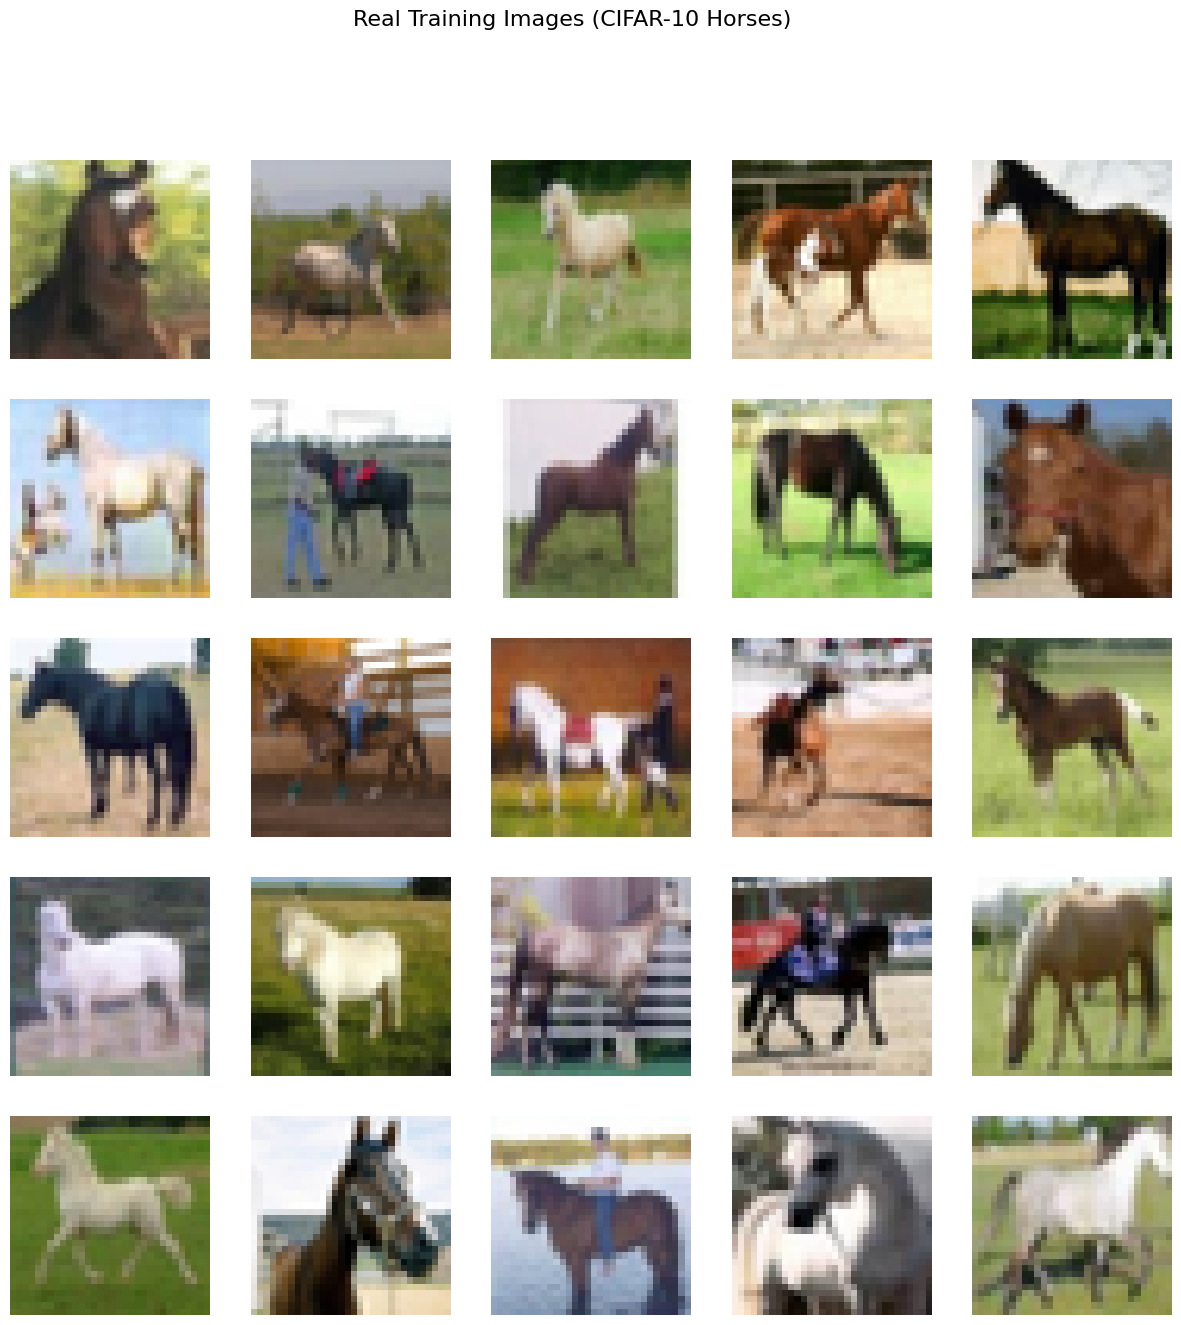

Saved real images to: ../run/gan/0002_horses/images/real.png


In [17]:
# =============================================================================
# Real Training Images Visualization
# =============================================================================
# Display a grid of real training images for visual comparison with
# generated samples. This helps assess how well the generator has learned.
# =============================================================================

# Grid dimensions
r, c = 5, 5

# Randomly sample images from the training set
idx = np.random.randint(0, x_train.shape[0], BATCH_SIZE)

# Rescale from [-1, 1] to [0, 1] for visualization
true_imgs = (x_train[idx] + 1) * 0.5

# Create the figure and subplot grid
fig, axs = plt.subplots(r, c, figsize=(15, 15))
cnt = 0

# Plot each image in the grid
for i in range(r):
    for j in range(c):
        axs[i, j].imshow(true_imgs[cnt])
        axs[i, j].axis("off")
        cnt += 1

plt.suptitle("Real Training Images (CIFAR-10 Horses)", fontsize=16)

# Display the figure in the notebook
plt.show()

# Save the figure
fig.savefig(os.path.join(RUN_FOLDER, "images/real.png"), dpi=300)
print(f"Saved real images to: {os.path.join(RUN_FOLDER, 'images/real.png')}")

## Generated Sample Images

This cell generates a 5x5 grid of images by sampling random noise vectors and passing them through the trained generator.

**What to look for:**
- **Diversity**: Are the generated horses varied in pose, color, and background?
- **Quality**: Do the images have recognizable horse-like features?
- **Artifacts**: Are there obvious visual glitches or noise patterns?

In [18]:
# =============================================================================
# Generated Sample Images Visualization
# =============================================================================
# Generate new images by sampling from the latent space and passing
# through the trained generator network.
# =============================================================================

# Grid dimensions
r, c = 5, 5

# Sample random noise vectors from standard normal distribution
noise = np.random.normal(0, 1, (r * c, gan.z_dim))

# Generate images using the trained generator
gen_imgs = gan.generator.predict(noise)

# Rescale from [-1, 1] to [0, 1] for visualization
gen_imgs = 0.5 * (gen_imgs + 1)

# Create the figure and subplot grid
fig, axs = plt.subplots(r, c, figsize=(15, 15))
cnt = 0

# Plot each generated image
for i in range(r):
    for j in range(c):
        axs[i, j].imshow(np.squeeze(gen_imgs[cnt, :, :, :]))
        axs[i, j].axis("off")
        cnt += 1

plt.suptitle("Generated Horse Images from WGAN", fontsize=16)

# Display the figure in the notebook
plt.show()

# Save the figure
fig.savefig(os.path.join(RUN_FOLDER, "images/sample.png"), dpi=300)
print(f"Saved generated samples to: {os.path.join(RUN_FOLDER, 'images/sample.png')}")

# Log generated images to W&B
log_images(
    [gen_imgs[i] for i in range(min(16, len(gen_imgs)))],
    key="final_generated_images"
)
print("✓ Generated images logged to W&B")

SyntaxError: '(' was never closed (889111357.py, line 18)

## Closest Matching Training Images

This cell finds the closest real training image for each generated sample using Mean Absolute Error (MAE) as the distance metric.

**Why this matters:**
This visualization helps detect **memorization** - if the generator is simply copying training images, the closest matches will be nearly identical to the generated samples. Ideally, generated images should be similar in style but not exact copies, indicating the model has learned the underlying data distribution rather than memorizing specific examples.

**What to look for:**
- Generated and closest images should be similar in style/content
- They should NOT be pixel-perfect matches (would indicate memorization)
- Diverse closest matches indicate good mode coverage

In [ ]:
# =============================================================================
# Closest Matching Training Images
# =============================================================================
# For each generated image, find the closest real training image.
# This helps verify the generator is learning the distribution,
# not simply memorizing training examples.
# =============================================================================

# Create the figure and subplot grid
fig, axs = plt.subplots(r, c, figsize=(15, 15))
cnt = 0

# Rescale training images for comparison
x_train_scaled = (x_train + 1) * 0.5

# Find closest match for each generated image
for i in range(r):
    for j in range(c):
        # Initialize with a large difference
        c_diff = 99999
        c_img = None

        # Search through all training images
        for k_idx, k in enumerate(x_train_scaled):
            # Compute Mean Absolute Error between generated and real image
            diff = compare_images(gen_imgs[cnt, :, :, :], k)

            # Update if this is the closest match so far
            if diff < c_diff:
                c_img = np.copy(k)
                c_diff = diff

        # Plot the closest matching real image
        axs[i, j].imshow(c_img)
        axs[i, j].axis("off")
        cnt += 1

plt.suptitle("Closest Real Images to Generated Samples", fontsize=16)

# Display the figure in the notebook
plt.show()

# Save the figure
fig.savefig(os.path.join(RUN_FOLDER, "images/sample_closest.png"), dpi=300)
print(f"Saved closest matches to: {os.path.join(RUN_FOLDER, 'images/sample_closest.png')}")

## Finalize W&B Run

Complete the W&B run and sync all logged data.

In [ ]:
# =============================================================================
# FINALIZE W&B RUN
# =============================================================================
# Complete the experiment run and sync all data to W&B servers.

wandb.finish()
print("✓ W&B run completed and synced")

## Cleanup: Restart Kernel

Restart the kernel to fully release GPU memory. TensorFlow/CUDA does not release
GPU memory within a running Python process - kernel restart is the only guaranteed method.

In [ ]:
# =============================================================================
# CLEANUP: Restart kernel to fully release GPU memory
# =============================================================================
# TensorFlow/CUDA does not release GPU memory within a running Python process.
# Restarting the kernel is the only guaranteed way to free all GPU resources.
#
# UNCOMMENT the lines below when you want to release GPU memory:

# import IPython
# print("Restarting kernel to release GPU memory...")
# IPython.Application.instance().kernel.do_shutdown(restart=True)

## Experiment Log

This section tracks all training experiments. **Full analysis details are logged to W&B and saved as markdown reports.**

### Master Experiment Log

| Run | Date | W&B URL | Batch Size | Epochs | LR | Stability | Final D Loss | Final G Loss | Notes |
|-----|------|---------|------------|--------|-----|-----------|--------------|--------------|-------|
| 001 | 2026-01-07 | [View](https://wandb.ai/cataluna84/generative-deep-learning/runs/x5ln97by) | 512 | 6000 | 5e-5 | ✅ Stable | 5.35 | -116.4 | Baseline |
| 002 | - | - | - | - | - | - | - | - | *Placeholder* |
| 003 | - | - | - | - | - | - | - | - | *Placeholder* |

### Comparison Notes

*Add observations comparing runs here after experiments.*

---

## What's Logged to W&B

Each run automatically logs the following (click W&B URL to view):

| Category | Items Logged |
|----------|--------------|
| **Config** | batch_size, epochs, lr_critic, lr_gen, n_critic, clip_threshold, z_dim |
| **Metrics** | d_loss, d_loss_real, d_loss_fake, g_loss (per epoch) |
| **Tables** | phase_metrics, stability_indicators |
| **Summary** | training_stability, training_quality, final losses, verdict |
| **Media** | Generated images, loss plots |

### Per-Run Analysis Reports

Each run generates `analysis_report.md` in the run folder containing:
- Training verdict (stability score)
- Full configuration table
- Phase-wise metrics breakdown
- Stability indicators with observations

